# **IMPORT LIBS AND DATASETS**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import pandas, time to impose rate limits
import numpy as np
import pandas as pd
import time
import os
import re
import string
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def read_data(filename):
    # read in csv
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Big Data/News_Analysis/New/(SB 142023)news-corpus-df.csv')

    # drop text under 500 words
    df = df.drop(df[df.text_len < 500].index)
    df.dropna(inplace = True)

    # limit df content to bias, text, headline, and source
    df = df.loc[:, ['main_headline', 'bias', 'text', 'text_len',  'source', 'Image_link']]

    # cleaning the 'bias' column of unnecessary white space
    df['bias'] = df['bias'].apply(lambda x: x.strip()) 

    # convert bias label to number
    df['bias'] = df['bias'].replace({'Left': 1, 'Center': 3, 'Right': 5})
    df['bias'] = df['bias'].replace({'Lean Left': 2, 'Lean Right': 4})

    return df

# read in file and preview
new = read_data('/content/drive/MyDrive/Colab Notebooks/Big Data/News_Analysis/New/(SB 142023)news-corpus-df.csv')
new.head()

,main_headline,bias,text,text_len,source,Image_link
0,"Who likes tariffs? Generally speaking, it's no...",1,The people who like the sort of tariffs that P...,3013,cnn,https://i2.cdn.turner.com/money/dam/assets/180...
1,"Trump escalates war on Twitter, social media p...",1,"FILE - In this Oct. 11, 2017, file photo, MSNB...",8726,apnews,https://storage.googleapis.com/afs-prod/media/...
3,Kavanaugh for the Court,3,Judge Brett Kavanaugh speaks after being nomin...,1062,wsj,https://s.wsj.net/img/meta/wsj-social-share.png
4,Exclusive: 'I'm here': Hunter Biden hits back ...,3,As President Donald Trump continues to fill hi...,15428,go,https://s.abcnews.com/images/US/Biden-intervie...
5,Trump made Twitter his megaphone. A fact check...,5,When President Donald Trump felt the need to l...,5703,nbcnews,https://media-cldnry.s-nbcnews.com/image/uploa...


In [4]:
new.shape[0]

265

## **ORGANIZE DATASETS INTO CHUNKS OF BIAS**

In [5]:
left = new.loc[new['bias'] ==1]
lean_left = new.loc[new['bias']==2]
center = new.loc[new['bias'] ==3]
lean_right = new.loc[new['bias']==4]
right = new.loc[new['bias'] ==5]

new = center.append(right, ignore_index=True)
new = new.append(left, ignore_index=True)
new = new.append(lean_right, ignore_index=True)
new = new.append(lean_left, ignore_index=True)
new.head()

<ipython-input-5-2f8d70709130>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = center.append(right, ignore_index=True)
<ipython-input-5-2f8d70709130>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = new.append(left, ignore_index=True)
<ipython-input-5-2f8d70709130>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = new.append(lean_right, ignore_index=True)
<ipython-input-5-2f8d70709130>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = new.append(lean_left, ignore_index=True)


,main_headline,bias,text,text_len,source,Image_link
0,Kavanaugh for the Court,3,Judge Brett Kavanaugh speaks after being nomin...,1062,wsj,https://s.wsj.net/img/meta/wsj-social-share.png
1,Exclusive: 'I'm here': Hunter Biden hits back ...,3,As President Donald Trump continues to fill hi...,15428,go,https://s.abcnews.com/images/US/Biden-intervie...
2,Republican reps cite 9/11 anniversary in criti...,3,Washington CNN —\nTwo Republican members of Co...,3281,cnn,https://media.cnn.com/api/v1/images/stellar/pr...
3,Brazilian president demands apology before acc...,3,Brazilian President Jair Bolsonaro said Tuesda...,4322,nbcnews,https://media-cldnry.s-nbcnews.com/image/uploa...
4,Amazon fires are not exactly burning 'Earth's ...,3,The Earth's lungs are on fire. They're burning...,2208,foxnews,https://static.foxnews.com/foxnews.com/content...


# **REMOVING STOPWORDS, STEMMING, LEMMATIZING**

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
def text_prepare(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower()
    text = text.replace('\n', ' ')

    letters = list(string.ascii_lowercase)
    numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    banned = ["’", "’", "“", "—", "”", "‘", "–", '#', '[', '/',
              '(', ')', '{', '}', '\\', '[', ']', '|', '@', ',', ';', '+', '-']
    banned = ''.join(banned) + string.punctuation + ''.join(numbers)
    boilerplate = ['  ', 'https', 'http', 'www', '’s', '―', '/', 'playback', 'get', 'mr', 'mrs', 'ms', 'dr', 'prof', 'news', 'report', 'unsubscribe', 'they', 'must', 'share', 'that', 'view', 'hide', 'copy', 'something', 'enlarge', 'reprint', 'read', '_', 'videos', 'autoplay', 'watched', 'press', '’ve', 'toggle', 'around', 'the', 's.', 'said', 'here©', 'ad', '#', 'andhis', 'click', 'r', 'device',
                   'contributed', 'advertisement', 'the washington', '&', 'follow', 'copyright', 'mrs.', 'photo', 'to', 'also', 'times', 'for', 'however', 'fox', 'this', 'copyright ©', 'ofs', 'just', 'wait', 'n’t', 'told', 'unsupported', 'i', 'caption', 'ms.', '’m', 'paste', '’re', 'replay', 'photos', 'mr.', '©', 'skip', 'watch', '2018', 'cut', 'llc', 'more', 'post', 'embed', 'blog', 'b.', 'associated', 'permission']
    stop_list = set(stopwords.words('english') + boilerplate + letters)

    translation_table = dict.fromkeys(map(ord, banned), ' ')
    text = text.translate(translation_table)
    text = re.sub(' +', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_list])
    return text


# rewrite df with cleaned text
for i in range(0, len(new)):
    new.at[i, 'text'] = text_prepare(new.at[i, 'text'])
    new.at[i, 'main_headline'] = text_prepare(new.at[i, 'main_headline'])

new.head()


,main_headline,bias,text,text_len,source,Image_link
0,kavanaugh court,3,judge brett kavanaugh speaks nominated preside...,1062,wsj,https://s.wsj.net/img/meta/wsj-social-share.png
1,exclusive hunter biden hits back trump taunt e...,3,president donald trump continues fill twitter ...,15428,go,https://s.abcnews.com/images/US/Biden-intervie...
2,republican reps cite anniversary criticizing t...,3,washington cnn two republican members congress...,3281,cnn,https://media.cnn.com/api/v1/images/stellar/pr...
3,brazilian president demands apology accepting ...,3,brazilian president jair bolsonaro tuesday acc...,4322,nbcnews,https://media-cldnry.s-nbcnews.com/image/uploa...
4,amazon fires exactly burning earth lungs exper...,3,earth lungs fire burning version politicians j...,2208,foxnews,https://static.foxnews.com/foxnews.com/content...


In [8]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_word(word):
    """
    Stem a word using the Porter stemming algorithm
    """
    return stemmer.stem(word)

def lemmatize_word(word):
    """
    Lemmatize a word using the WordNet lemmatization algorithm
    """
    # Get the part of speech for the word
    pos = wordnet.synsets(word)[0].pos() if wordnet.synsets(word) else 'n'
    # Map the part of speech to the corresponding WordNet constant
    if pos.startswith('J'):
        pos = wordnet.ADJ
    elif pos.startswith('V'):
        pos = wordnet.VERB
    elif pos.startswith('N'):
        pos = wordnet.NOUN
    elif pos.startswith('R'):
        pos = wordnet.ADV
    else:
        pos = wordnet.NOUN
    # Lemmatize the word using the appropriate part of speech
    return lemmatizer.lemmatize(word, pos)

def preprocess_text(text):
    """
    Preprocess a block of text by tokenizing, stemming, and lemmatizing each word
    """
    tokens = word_tokenize(text)
    stemmed = [stem_word(token) for token in tokens]
    lemmatized = [lemmatize_word(token) for token in stemmed]
    return ' '.join(lemmatized)

In [9]:
for i in range(0, len(new)):
    new.at[i, 'text'] = preprocess_text(new.at[i, 'text'])
    new.at[i, 'main_headline'] = preprocess_text(new.at[i, 'main_headline'])

new.head()

,main_headline,bias,text,text_len,source,Image_link
0,kavanaugh court,3,judg brett kavanaugh speak nomin presid donald...,1062,wsj,https://s.wsj.net/img/meta/wsj-social-share.png
1,exclus hunter biden hit back trump taunt exclu...,3,presid donald trump continu fill twitter feed ...,15428,go,https://s.abcnews.com/images/US/Biden-intervie...
2,republican rep cite anniversari critic trump d...,3,washington cnn two republican member congress ...,3281,cnn,https://media.cnn.com/api/v1/images/stellar/pr...
3,brazilian presid demand apolog accept help fig...,3,brazilian presid jair bolsonaro tuesday accept...,4322,nbcnews,https://media-cldnry.s-nbcnews.com/image/uploa...
4,amazon fire exactli burn earth lung expert say,3,earth lung fire burn version politician journa...,2208,foxnews,https://static.foxnews.com/foxnews.com/content...


# **SENTIMENT ANALYSIS**

Here we use AFINN for text sentiment analysis (the reason why we need to say "text" will be explained later).

The AFINN lexicon assigns words with a score that runs between -5 and 5, with negative scores indicating negative sentiment and positive scores indicating positive sentiment. However, it is possible for the sentiment score of AFINN model to be exceeded the [-5;5] range as it is just a lexicon that assigns scores to words based on their polarity. The score of a sentence is calculated by summing up the scores of each word in the sentence. Therefore, it is possible for a sentence to have a score that exceeds the [-5;5] range if it contains many words with high polarity scores.

As you can see, our data consists of news crawled from digital newspapers and they have lengths that are more than 500 words. Some goes up to 15000+ words. So the result of our sentiment analysis may be suspicious at your very first glance. 

In [10]:
!pip install --upgrade afinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 KB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53448 sha256=7544c7c73eedb3137846cf8a3a0e5e7b017ea12ec9bb8176a3f86699c81f9e0c
  Stored in directory: /root/.cache/pip/wheels/79/91/ee/8374d9bc8c6c0896a2db75afdfd63d43653902407a0e76cd94
Successfully built afinn


In [11]:
from afinn import Afinn
import re
afinn = Afinn()
sentiment_list = []
magnitude_list = []

for text in new['text']:
    # Compute sentiment score
    sentiment_score = afinn.score(text)
    sentiment_list.append(sentiment_score)
    # Compute magnitude score
    magnitude_score = sum(abs(afinn.score(word)) for word in text.split() if word in afinn._dict)
    magnitude_list.append(magnitude_score)

    # wait a second to add delay to query
    time.sleep(.100)

# Add sentiment information to data frame
new = new.assign(sentiment=sentiment_list)
new = new.assign(magnitude=magnitude_list)
new.head(11)

,main_headline,bias,text,text_len,source,Image_link,sentiment,magnitude
0,kavanaugh court,3,judg brett kavanaugh speak nomin presid donald...,1062,wsj,https://s.wsj.net/img/meta/wsj-social-share.png,4.0,6.0
1,exclus hunter biden hit back trump taunt exclu...,3,presid donald trump continu fill twitter feed ...,15428,go,https://s.abcnews.com/images/US/Biden-intervie...,59.0,171.0
2,republican rep cite anniversari critic trump d...,3,washington cnn two republican member congress ...,3281,cnn,https://media.cnn.com/api/v1/images/stellar/pr...,-14.0,40.0
3,brazilian presid demand apolog accept help fig...,3,brazilian presid jair bolsonaro tuesday accept...,4322,nbcnews,https://media-cldnry.s-nbcnews.com/image/uploa...,8.0,82.0
4,amazon fire exactli burn earth lung expert say,3,earth lung fire burn version politician journa...,2208,foxnews,https://static.foxnews.com/foxnews.com/content...,-16.0,28.0
5,racist tweet medium grappl label trump latest ...,3,comment stori comment gift articl time call st...,6298,washingtonpost,https://www.washingtonpost.com/wp-apps/imrs.ph...,-76.0,118.0
6,republican longer fear tucker carlson,3,widespread republican critic tucker carlson re...,4330,newsweek,0,-63.0,73.0
7,reopen hillari email case matter,3,make mistak enjoy reviv fbi interest hillari c...,6279,townhall,https://media.townhall.com/cdn/hodl/2016/272/7...,23.0,97.0
8,biden say democraci prevail elector colleg for...,3,presid elect joe biden emphas uniti speech mon...,1543,axios,https://images.axios.com/0PwpU3ma9LrM-cONebxni...,16.0,24.0
9,twitter fact check trump trump cri free speech,3,twitter trump collis cours truth twitter appli...,5933,usatoday,https://www.gannett-cdn.com/presto/2019/07/26/...,-46.0,96.0


In [12]:
def score_to_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

new['senti'] = new['sentiment'].apply(score_to_sentiment)
new.head()

,main_headline,bias,text,text_len,source,Image_link,sentiment,magnitude,senti
0,kavanaugh court,3,judg brett kavanaugh speak nomin presid donald...,1062,wsj,https://s.wsj.net/img/meta/wsj-social-share.png,4.0,6.0,positive
1,exclus hunter biden hit back trump taunt exclu...,3,presid donald trump continu fill twitter feed ...,15428,go,https://s.abcnews.com/images/US/Biden-intervie...,59.0,171.0,positive
2,republican rep cite anniversari critic trump d...,3,washington cnn two republican member congress ...,3281,cnn,https://media.cnn.com/api/v1/images/stellar/pr...,-14.0,40.0,negative
3,brazilian presid demand apolog accept help fig...,3,brazilian presid jair bolsonaro tuesday accept...,4322,nbcnews,https://media-cldnry.s-nbcnews.com/image/uploa...,8.0,82.0,positive
4,amazon fire exactli burn earth lung expert say,3,earth lung fire burn version politician journa...,2208,foxnews,https://static.foxnews.com/foxnews.com/content...,-16.0,28.0,negative


In [13]:
new['senti'].value_counts()

negative    164
positive     88
neutral      13
Name: senti, dtype: int64

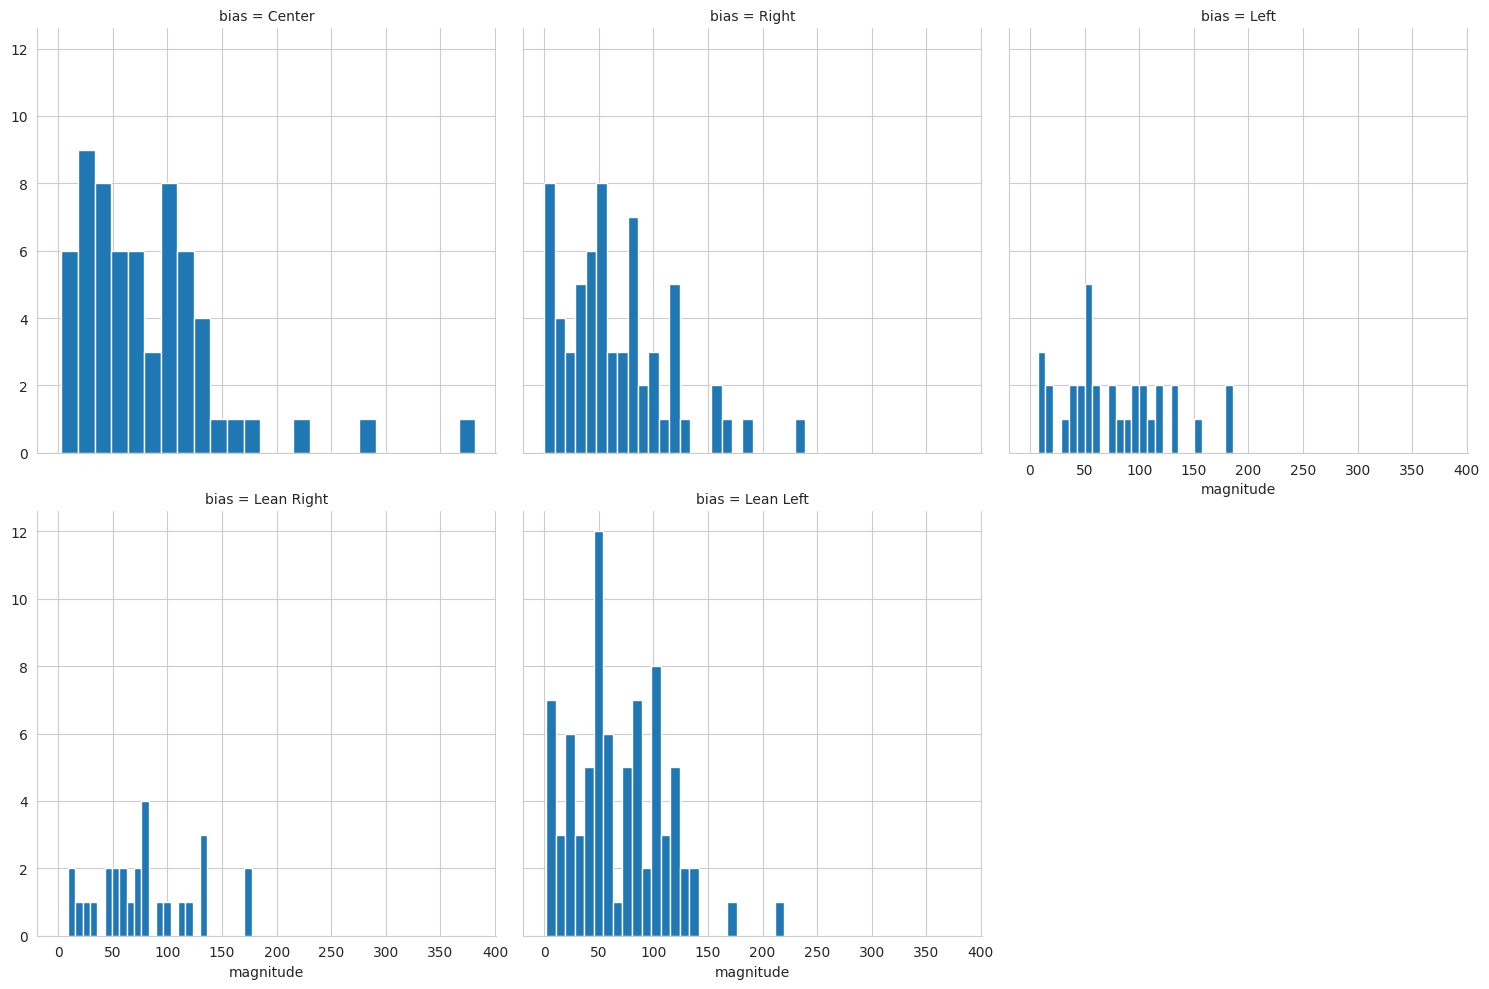

In [14]:
new.to_csv('news-corpus-df-sent.csv', sep='\t', encoding='utf-8')

# convert bias numbers to labels
new['bias'] = new['bias'].replace({1: 'Left', 2: 'Lean Left', 3: 'Center', 4: 'Lean Right', 5: 'Right'})
sns.set_style('whitegrid')
# visualize sentiment in relation to bias

g = sns.FacetGrid(data=new, col='bias', col_wrap= 3, height=5 )
g.map(plt.hist, 'magnitude', bins=25)
plt.savefig('histogram.png', bbox_inches='tight')


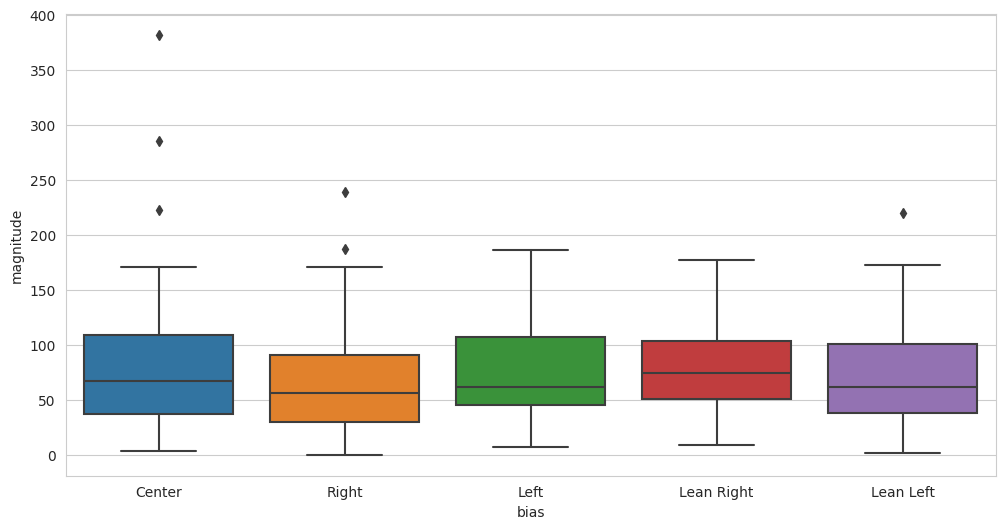

In [15]:
plt.figure(figsize=(12,6))
sns.boxplot(x='bias', y='magnitude', data=new)
plt.savefig('boxplot.png', bbox_inches='tight')

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.2`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.2`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` i

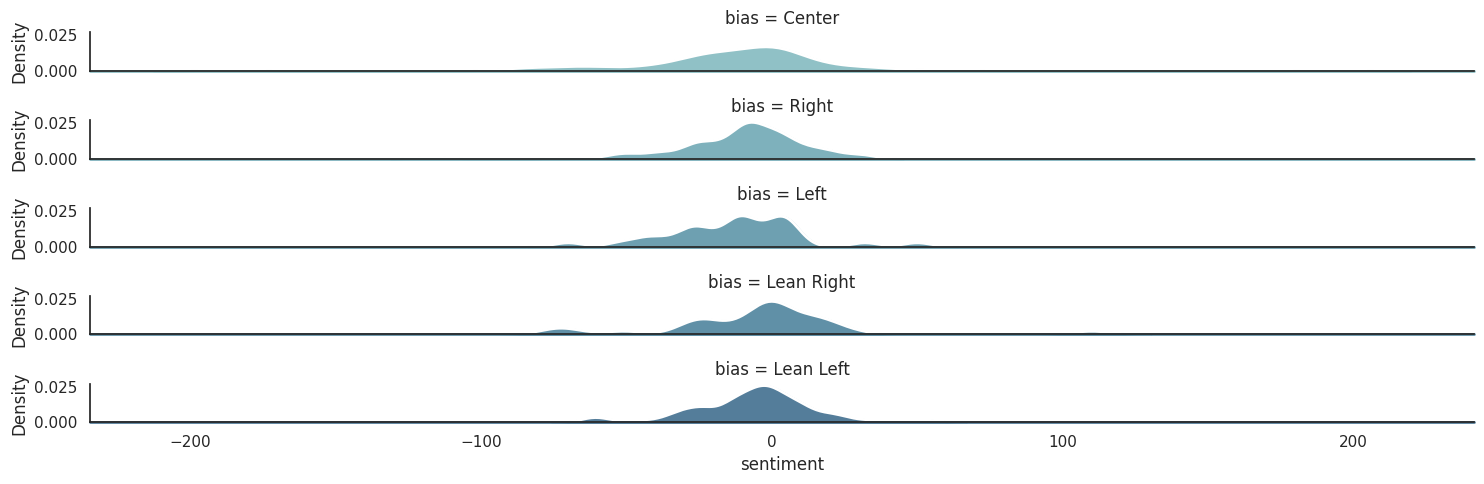

In [16]:
def densityplot(dimension):

    # Initialize the FaceGrid object
    sns.set(style="white", rc={'axes.facecolor': (0, 0, 0, 0)})
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(new, row="bias", hue="bias",
                      aspect=15, height=1, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, dimension, clip_on=False,
          shade=True, alpha=1, lw=1.5, bw=.2)
    g.map(sns.kdeplot, dimension, clip_on=False, color='w', lw=2, bw=.2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight='bold', color=color,
                ha='left', va='center', transform=ax.transAxes)

        # Set the subplot to overlap
        g.map(label, dimension)

        # Remove axes details that don't play will with overlap
        g.set_titles('')
        g.set(yticks=[])
        g.despine(bottom=True, left=True)

        return g

sentiment_plot = densityplot('sentiment') 

plt.savefig('density_plot.png', bbox_inches='tight')



# **CONTENT-BASED IMAGE SEARCH**

Content-based image search is a technique used to search for images based on their visual content rather than text-based metadata such as tags or descriptions. The basic idea behind content-based image search is to use visual features of images to find similar images in a database.

The process starts by extracting features from the images, such as color, texture, and shape. These features are then used to create a mathematical representation of the image, which is stored in a database. When a user inputs a query image, its features are also extracted, and the system searches the database for images with similar features. The results are then ranked based on their similarity to the query image.

One of the advantages of content-based image search is that it does not rely on human annotations or tags, which can be inconsistent and incomplete. It also allows for more specific and accurate searches based on visual similarities, which can be difficult to describe in text-based searches. Additionally, content-based image search can be used for a wide range of applications, such as image retrieval, visual surveillance, and medical imaging.

However, content-based image search also has some limitations. For example, it can be computationally expensive to extract and compare features for large databases. It can also be difficult to capture all the relevant visual features of an image, which can lead to false positives or missed results. Additionally, content-based image search is less effective when searching for abstract concepts or when the image features are not well-defined.

Overall, content-based image search is a powerful tool for searching and retrieving images based on their visual content. It can provide more accurate and specific results than text-based searches, but it also has its limitations and challenges.

In [ ]:
# create df that contains the original df
dt = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Big Data/News_Analysis/New/(SB 142023)news-corpus-df.csv')
dt = dt.loc[:,['data', 'description', 'source', 'link', 'Image_link']]

In [ ]:
dt = dt[(dt['Image_link'] != '0')]

In [ ]:
dt.reset_index(drop=True, inplace=True)
dt.head()

,data,description,source,link,Image_link
0,2018-03-08T15:34:58-08:00,The people who like the sort of tariffs that P...,cnn,http://money.cnn.com/2018/03/05/news/economy/t...,https://i2.cdn.turner.com/money/dam/assets/180...
1,2020-05-28T07:02:58-07:00,President Donald Trump is preparing to sign an...,apnews,https://apnews.com/fc30f9ebdff9d3d33a870e7374f...,https://storage.googleapis.com/afs-prod/media/...
2,2019-12-12T06:52:09-08:00,The Justice Department’s top watchdog on Wedne...,politico,https://www.politico.com/news/2019/12/11/horow...,https://cf-images.us-east-1.prod.boltdns.net/v...
3,2018-07-12T12:49:56-07:00,President Trump kept everyone guessing to the ...,wsj,https://www.wsj.com/articles/kavanaugh-for-the...,https://s.wsj.net/img/meta/wsj-social-share.png
4,2019-10-17T06:20:50-07:00,As President Donald Trump continues to fill hi...,go,https://abcnews.go.com/Politics/exclusive-hidi...,https://s.abcnews.com/images/US/Biden-intervie...


In [ ]:
dt.shape[0]

285

In [ ]:
dt.isnull().sum()

data           0
description    0
source         0
link           0
Image_link     0
dtype: int64

In [ ]:
import requests

# Remove rows with inaccessible image links
indices_to_remove = []
for index, row in dt.iterrows():
    url = row['Image_link']
    try:
        response = requests.head(url, allow_redirects=False)
        if response.status_code >= 400:
            indices_to_remove.append(index)
            print(f"Dropped row {index} due to error {response.status_code}")
    except requests.exceptions.RequestException as e:
        indices_to_remove.append(index)
        print(f"Dropped row {index} due to exception {e}")
dt.drop(indices_to_remove, inplace=True)
dt.reset_index(drop=True, inplace=True)

Dropped row 16 due to error 404
Dropped row 21 due to error 401
Dropped row 29 due to error 404
Dropped row 39 due to error 404
Dropped row 44 due to error 404
Dropped row 57 due to error 400
Dropped row 60 due to error 401
Dropped row 69 due to error 404
Dropped row 76 due to error 404
Dropped row 93 due to error 404
Dropped row 94 due to error 404
Dropped row 101 due to error 404
Dropped row 107 due to error 405
Dropped row 129 due to error 401
Dropped row 136 due to error 404
Dropped row 138 due to error 401
Dropped row 140 due to error 400
Dropped row 186 due to error 401
Dropped row 191 due to error 400
Dropped row 205 due to error 404
Dropped row 224 due to error 403
Dropped row 243 due to error 400
Dropped row 248 due to error 404
Dropped row 252 due to error 404
Dropped row 264 due to error 401
Dropped row 268 due to error 405
Dropped row 271 due to error 404
Dropped row 280 due to error 404
Dropped row 284 due to error 404


In [ ]:
dt.reset_index(drop=True, inplace=True)
dt.shape[0]

256

In [ ]:
import numpy as np
from io import BytesIO
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.neighbors import NearestNeighbors
from keras.utils import load_img, img_to_array

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False)

# Define a function to extract features from an image using the VGG16 model
def extract_features(img_path):
    try:
        response = requests.get(img_path)
        img = load_img(BytesIO(response.content), target_size=(224, 224))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features = model.predict(x)
        return features.flatten()
    except:
        print(f"Unable to process image: {img_path}")
        return None
    
# Extract features from all images in your dataset and store them in a numpy array
image_features = []
image_links = []
indices_to_remove = []

for i, img_path in enumerate(dt['Image_link']):
    features = extract_features(img_path)
    if features is not None:
        image_features.append(features)
        image_links.append(img_path)
    else:
        indices_to_remove.append(i)

# Remove inaccessible image links from dt dataframe
indices_to_remove = [i for i in indices_to_remove if i < len(dt)]
dt.drop(dt.index[indices_to_remove], inplace=True)
dt.reset_index(drop=True, inplace=True)

# Update indices_to_remove based on the new length of dt
indices_to_remove = [i for i in indices_to_remove if i < len(dt)]

# Remove inaccessible image features from image_features array
image_features = np.array(image_features)
image_features = np.delete(image_features, indices_to_remove, axis=0)

# Print the indices of the most similar images for each image in your dataset
nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto').fit(image_features)
distances, indices = nbrs.kneighbors(image_features)
for i in range(len(indices)):
    print(f"Similar images for {dt.loc[i, 'Image_link']}:")
    print(dt.loc[indices[i], 'Image_link'])

1/1 [==============================] - 0s 406ms/step
Unable to process image: https://cdn.townhall.com/web/thm/pjmedia-placeholder.svg
1/1 [==============================] - 0s 409ms/step
Unable to process image: https://spectator.org/a-super-speech/
1/1 [==============================] - 1s 601ms/step
Similar images for https://i2.cdn.turner.com/money/dam/assets/180301131556-steel-tariffs-780x439.jpg:
0      https://i2.cdn.turner.com/money/dam/assets/180...
154    https://cdn.vox-cdn.com/thumbor/62JptvpnNkoUxy...
230    https://www.washingtonpost.com/wp-apps/imrs.ph...
Name: Image_link, dtype: object
Similar images for https://storage.googleapis.com/afs-prod/media/c9fb58f6d12f4c52b166953eacbe23e6/3000.jpeg:
1      https://storage.googleapis.com/afs-prod/media/...
198    https://compote.slate.com/images/9ef1ea1d-e96a...
18     https://media.npr.org/assets/img/2020/02/19/ap...
Name: Image_link, dtype: object
Similar images for https://cf-images.us-east-1.prod.boltdns.net/v1/static/11559

In [ ]:
import urllib.request

In [ ]:
# Create a new DataFrame to store the indices of the similar images
d = pd.DataFrame(columns=['similar_images'])
d['similar_images'] = indices.tolist()
print(d['similar_images'].count())

252


In [ ]:
missing_indices = set(dt.index) - set(d.index)
print(missing_indices)

{252, 253}


In [ ]:
dt.drop(missing_indices, inplace=True)
dt.reset_index(drop=True, inplace=True)

In [ ]:
d.shape[0]

252

In [ ]:
dt.shape[0]

252

In [ ]:
dt = dt.join(d)

In [ ]:
# Save the updated DataFrame to a file
dt.to_csv('/content/drive/MyDrive/Colab Notebooks/Big Data/News_Analysis/New/analyzing_and_same_images.csv', index=False)

# Create a directory to store the downloaded images
if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/Big Data/News_Analysis/New/Images'):
    os.makedirs('/content/drive/MyDrive/Colab Notebooks/Big Data/News_Analysis/New/Images')

import urllib

for i in range(len(d)):
    image_url = dt.loc[i, 'Image_link']
    similar_indices = dt.loc[i, 'similar_images']
    
    # Download the image
    image_path = f"/content/drive/MyDrive/Colab Notebooks/Big Data/News_Analysis/New/Images/image_{i}.jpg"
    try:
        urllib.request.urlretrieve(image_url, image_path)
    except:
        print(f"Error downloading image {image_url}")
        continue

    # Download the similar images
    for j in similar_indices:
        similar_image_url = dt.loc[j, 'Image_link']
        similar_image_path = f"/content/drive/MyDrive/Colab Notebooks/Big Data/News_Analysis/New/Images/image_{i}_similar_{j}.jpg"
        try:
            urllib.request.urlretrieve(similar_image_url, similar_image_path)
        except:
            print(f"Error downloading similar image {similar_image_url}")
            continue


Error downloading image https://bigthink.com/wp-content/uploads/2018/08/origin-26.jpg?resize=1200,630
Error downloading image https://images.axios.com/0PwpU3ma9LrM-cONebxniN60w6o=/0x54:3279x1898/1366x768/2020/12/15/1607993351207.jpg
Error downloading similar image https://bigthink.com/wp-content/uploads/2018/08/origin-26.jpg?resize=1200,630
Error downloading similar image https://bigthink.com/wp-content/uploads/2018/08/origin-26.jpg?resize=1200,630
Error downloading similar image https://bigthink.com/wp-content/uploads/2018/08/origin-26.jpg?resize=1200,630
Error downloading similar image https://bigthink.com/wp-content/uploads/2018/08/origin-26.jpg?resize=1200,630
Error downloading similar image https://bigthink.com/wp-content/uploads/2018/08/origin-26.jpg?resize=1200,630
Error downloading image https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/BKMY66QFLAI6TFMMBJQBEJX7NM.jpg&amp;w=1440
Error downloading similar ima

# **IMAGE SENTIMENT ANALYSIS**

In this part, our dataset was't labeled so we will do this part in a different way. 

First, we will try to divide the images into clusters based on some of their features. Then, we label a small subset in the clusters and use it to train the model and predict the rest of the dataset.

Another approach is to use transfer learning (which we have done in the previous part).

It should be like that but in our case, we don't have much time left for the project so we will assume that the sentiment result of the text (news) is the label of the images. We will split our dataset into 2 parts (train and test data). The ratio will be 85:15.

Finally, we will compare the result of image sentiment analysis and text analysis to evaluate the performance of the model. 


**A SMALL INTRODUCTION INTO IMAGE SENTIMENT ANALYSIS:**

Sentiments are feelings, emotions likes and dislikes or opinions which can be articulate through text, images or videos. Sentiment Analysis on web data is now becoming a budding research area of social analytics. Users express their sentiments on the web by exchanging texts and uploading images through a variety of social media like Instagram, Facebook, Twitter, WhatsApp etc. A lot of research work has been done for sentiment analysis of textual data; there has been limited work that focuses on analyzing the sentiment of image data. Image sentiment concepts are ANPs i.e. Adjective Noun Pairs automatically discovered tags of web images which are useful for detecting the emotions or sentiments conveyed by the image. The major challenge is to predict or identify the sentiments of unlabelled images. To overcome this challenge deep learning techniques are used for sentiment analysis, as deep learning models have the capability for effectively learning the image behavior or polarity. Image recognition, image prediction, image sentiment analysis, and image classification are some of the fields where Neural Network (NN) has performed well implying significant performance of deep learning in image sentiment analysis. This paper focuses on some of the noteworthy models of deep learning as Deep Neural Network (DNN), Convolutional Neural Network (CNN), Region-based CNN (R-CNN) and Fast R-CNN along with the suitability of their applications in image sentiment analysis and their limitations. The study also discusses the challenges and perspectives of this rising field.

(N. Mittal, D. Sharma and M. L. Joshi, "Image Sentiment Analysis Using Deep Learning," 2018 IEEE/WIC/ACM International Conference on Web Intelligence (WI), Santiago, Chile, 2018, pp. 684-687, doi: 10.1109/WI.2018.00-11.)

Image sentiment analysis is a process of using computer vision and natural language processing techniques to analyze the emotions and sentiments conveyed by an image. The goal is to automatically recognize the emotions and feelings of people or objects within the image. This can be useful in various applications, such as social media monitoring, brand reputation management, and market research.

The process of image sentiment analysis typically involves several steps, including image preprocessing, feature extraction, and sentiment classification. Image preprocessing involves resizing, cropping, and normalizing the image to improve the accuracy of feature extraction. Feature extraction involves using techniques such as convolutional neural networks (CNNs) to extract relevant visual features from the image. Sentiment classification involves using natural language processing (NLP) techniques to classify the emotions conveyed by the image, such as happy, sad, angry, etc.

Overall, image sentiment analysis is a challenging task due to the complexity of human emotions and the variability of visual cues. However, recent advances in deep learning and computer vision have shown promising results in this area, making it a rapidly growing research field.

## **PREPROCESSING IMAGE LINKS**

In [ ]:
new.shape[0]

265

In [ ]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   main_headline  265 non-null    object 
 1   bias           265 non-null    object 
 2   text           265 non-null    object 
 3   text_len       265 non-null    int64  
 4   source         265 non-null    object 
 5   Image_link     265 non-null    object 
 6   sentiment      265 non-null    float64
 7   magnitude      265 non-null    float64
 8   senti          265 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 18.8+ KB


In [ ]:
new = new[(new['Image_link'] != '0')]
new.reset_index(drop=True, inplace=True)
new.head()

,main_headline,bias,text,text_len,source,Image_link,sentiment,magnitude,senti
0,kavanaugh court,Center,judg brett kavanaugh speak nomin presid donald...,1062,wsj,https://s.wsj.net/img/meta/wsj-social-share.png,4.0,6.0,neutral
1,exclus hunter biden hit back trump taunt exclu...,Center,presid donald trump continu fill twitter feed ...,15428,go,https://s.abcnews.com/images/US/Biden-intervie...,59.0,171.0,positive
2,republican rep cite anniversari critic trump d...,Center,washington cnn two republican member congress ...,3281,cnn,https://media.cnn.com/api/v1/images/stellar/pr...,-14.0,40.0,negative
3,brazilian presid demand apolog accept help fig...,Center,brazilian presid jair bolsonaro tuesday accept...,4322,nbcnews,https://media-cldnry.s-nbcnews.com/image/uploa...,8.0,82.0,positive
4,amazon fire exactli burn earth lung expert say,Center,earth lung fire burn version politician journa...,2208,foxnews,https://static.foxnews.com/foxnews.com/content...,-16.0,28.0,negative


In [ ]:
new.shape[0]

247

In [ ]:
import requests

In [ ]:
# Remove rows with inaccessible image links
indices_to_remove = []
for index, row in new.iterrows():
    url = row['Image_link']
    try:
        response = requests.head(url, allow_redirects=False)
        if response.status_code >= 400:
            indices_to_remove.append(index)
            print(f"Dropped row {index} due to error {response.status_code}")
    except requests.exceptions.RequestException as e:
        indices_to_remove.append(index)
        print(f"Dropped row {index} due to exception {e}")
new = new.loc[~new.index.isin(indices_to_remove)]
new.reset_index(drop=True, inplace=True)

Dropped row 21 due to error 404
Dropped row 32 due to error 404
Dropped row 62 due to error 404
Dropped row 65 due to error 401
Dropped row 75 due to error 401
Dropped row 83 due to error 404
Dropped row 92 due to error 400
Dropped row 116 due to error 404
Dropped row 119 due to error 405
Dropped row 124 due to error 404
Dropped row 125 due to error 404
Dropped row 136 due to error 401
Dropped row 142 due to error 400
Dropped row 148 due to error 404
Dropped row 166 due to error 404
Dropped row 170 due to error 405
Dropped row 172 due to error 404
Dropped row 176 due to error 404
Dropped row 178 due to error 404
Dropped row 193 due to error 404
Dropped row 201 due to error 401
Dropped row 204 due to error 401
Dropped row 215 due to error 405
Dropped row 218 due to error 404
Dropped row 234 due to error 404
Dropped row 238 due to error 401
Dropped row 241 due to error 404


In [ ]:
indices_to_remove = []
for index, row in new.iterrows():
    url = row['Image_link']
    try:
        response = requests.get(url)
        if response.status_code == 200:
            content_type = response.headers['Content-Type']
            if 'image' not in content_type:
                indices_to_remove.append(index)
                print(f"Dropped row {index} - {url} is not an image")
            else:
                img_data = response.content
                if img_data is None:
                    indices_to_remove.append(index)
                    print(f"Dropped row {index} - {url} returned None type image")
        else:
            indices_to_remove.append(index)
            print(f"Dropped row {index} - {url} returned status code {response.status_code}")
    except requests.exceptions.RequestException as e:
        indices_to_remove.append(index)
        print(f"Dropped row {index} - {e}")
new = new.loc[~new.index.isin(indices_to_remove)]
new.reset_index(drop=True, inplace=True)

Dropped row 148 - https://spectator.org/a-super-speech/ is not an image


## **IMAGE SENTIMENT ANALYSIS** 


### WITH PYTORCH

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import os
import requests
import torch.optim as optim
from torchvision import models
import torchvision.models as models

In [ ]:
# Create a directory to store the images
if not os.path.exists("images"):
    os.mkdir("images")

# Define a function to download and save images locally
def download_image(url, folder):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        # Extract filename from URL
        filename = os.path.join(folder, os.path.basename(url))
        # Save image to file
        with open(filename, 'wb') as f:
            f.write(response.content)
        return filename
    else:
        return None
# Create a new column in the DataFrame for the local image path
new['Image_path'] = ''

# Download and save images
for index, row in new.iterrows():
    img_url = row['Image_link']
    try:
        response = requests.get(img_url, stream=True)
        if response.status_code == 200:
            img_path = download_image(img_url, 'images')
            if img_path is not None:
                new.at[index, 'Image_path'] = img_path
            else:
                print(f"Failed to download image at index {index}: {img_url}")
                new.drop(index, inplace=True)
        else:
            print(f"Failed to access image at index {index}: {img_url}")
            new.drop(index, inplace=True)
    except:
        print(f"Failed to access image at index {index}: {img_url}")
        new.drop(index, inplace=True)

# Remove rows where image download failed
new = new[new['Image_path'] != '']

# Remove corrupted images
for index, row in new.iterrows():
    img_path = row['Image_path']
    try:
        img = Image.open(img_path)
        if img is None:
            print("Removing corrupted image: ", img_path)
            os.remove(img_path)
            new.drop(index, inplace=True)
    except:
        print("Removing corrupted image: ", img_path)
        os.remove(img_path)
        new.drop(index, inplace=True)

new.dropna(inplace=True)
new.reset_index(drop=True, inplace=True)

Removing corrupted image:  images/pjmedia-placeholder.svg


In [ ]:
new.head()

,main_headline,bias,text,text_len,source,Image_link,sentiment,magnitude,senti,Image_path
0,kavanaugh court,Center,judg brett kavanaugh speak nomin presid donald...,1062,wsj,https://s.wsj.net/img/meta/wsj-social-share.png,4.0,6.0,neutral,images/wsj-social-share.png
1,exclus hunter biden hit back trump taunt exclu...,Center,presid donald trump continu fill twitter feed ...,15428,go,https://s.abcnews.com/images/US/Biden-intervie...,59.0,171.0,positive,images/Biden-interview-5577c-abc-ps-191014_hpM...
2,republican rep cite anniversari critic trump d...,Center,washington cnn two republican member congress ...,3281,cnn,https://media.cnn.com/api/v1/images/stellar/pr...,-14.0,40.0,negative,images/w_800
3,brazilian presid demand apolog accept help fig...,Center,brazilian presid jair bolsonaro tuesday accept...,4322,nbcnews,https://media-cldnry.s-nbcnews.com/image/uploa...,8.0,82.0,positive,images/190827-emmanuel-macron-jair-bolsonaro-c...
4,amazon fire exactli burn earth lung expert say,Center,earth lung fire burn version politician journa...,2208,foxnews,https://static.foxnews.com/foxnews.com/content...,-16.0,28.0,negative,images/AP-amazon-fire.jpg


In [ ]:
# Define a custom dataset class
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data = df
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["Image_path"]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, idx
    
class ResNet18(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet18, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
        self.resnet.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        return x

# Define the transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Define the dataset
dataset = ImageDataset(new, transform=transform)

# Define the dataloader
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Define the device to use for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create an instance of the ResNet18 model
model = ResNet18(num_classes=1).to(device)

# Set the model to evaluation mode
model.eval()

# Evaluate the model on the dataset
predictions = []
indices = []
with torch.no_grad():
    for data, idx in dataloader:
        data = data.to(device)
        output = model(data)
        prediction = torch.sigmoid(output).cpu().detach().numpy()[0][0]
        predictions.append(prediction)
        indices.append(idx)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [ ]:
# Create a new DataFrame with the original data and the predictions
results = pd.DataFrame({
    "Image_path": dataset.data["Image_path"],
    "Sentiment": predictions
})

# Add the predictions to the original DataFrame
dataset.data["Sentiment"] = results["Sentiment"]

In [ ]:
results.head()

,Image_path,Sentiment
0,images/wsj-social-share.png,0.550776
1,images/Biden-interview-5577c-abc-ps-191014_hpM...,0.630898
2,images/w_800,0.374618
3,images/190827-emmanuel-macron-jair-bolsonaro-c...,0.609227
4,images/AP-amazon-fire.jpg,0.534967


In [ ]:
for i, row in dataset.data.iterrows():
    if row["Sentiment"] > 0.5:
        dataset.data.at[i, "Sentiment"] = "positive"
    elif row["Sentiment"] > 0.5:
        dataset.data.at[i, "Sentiment"] = "negative"
    else:
        dataset.data.at[i, "Sentiment"] = "neutral"

In [ ]:
dataset.data.head()

,main_headline,bias,text,text_len,source,Image_link,sentiment,magnitude,senti,Image_path,Sentiment
0,kavanaugh court,Center,judg brett kavanaugh speak nomin presid donald...,1062,wsj,https://s.wsj.net/img/meta/wsj-social-share.png,4.0,6.0,neutral,images/wsj-social-share.png,positive
1,exclus hunter biden hit back trump taunt exclu...,Center,presid donald trump continu fill twitter feed ...,15428,go,https://s.abcnews.com/images/US/Biden-intervie...,59.0,171.0,positive,images/Biden-interview-5577c-abc-ps-191014_hpM...,positive
2,republican rep cite anniversari critic trump d...,Center,washington cnn two republican member congress ...,3281,cnn,https://media.cnn.com/api/v1/images/stellar/pr...,-14.0,40.0,negative,images/w_800,neutral
3,brazilian presid demand apolog accept help fig...,Center,brazilian presid jair bolsonaro tuesday accept...,4322,nbcnews,https://media-cldnry.s-nbcnews.com/image/uploa...,8.0,82.0,positive,images/190827-emmanuel-macron-jair-bolsonaro-c...,positive
4,amazon fire exactli burn earth lung expert say,Center,earth lung fire burn version politician journa...,2208,foxnews,https://static.foxnews.com/foxnews.com/content...,-16.0,28.0,negative,images/AP-amazon-fire.jpg,positive


In [ ]:
# Save the updated DataFrame
dataset.data.to_csv('/content/drive/MyDrive/Colab Notebooks/Big Data/News_Analysis/New/image_sentiment.csv', index=False)